# HM1: Logistic Regression.

### Name: John Graham


#### For this assignment, you will build 6 models. You need to train Logistic Regression/Regularized Logistic Regression each with Batch Gradient Descent, Stochastic Gradient Descent and Mini Batch Gradient Descent. Also you should plot their objective values versus epochs and compare their training and testing accuracies. You will need to tune the parameters a little bit to obtain reasonable results.

#### You do not have to follow the following procedure. You may implement your own functions and methods, but you need to show your results and plots.

In [1]:
# Load Packages
import pandas as pd
from sklearn.model_selection import train_test_split

/var/folders/py/s_w913gs3bb7rnwkzr95m8440000gn/T/ipykernel_9106/4044457113.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1. Data processing

- Download the Breast Cancer dataset from canvas or from https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
- Load the data.
- Preprocess the data.

## 1.1. Load the data

In [2]:
data = pd.read_csv("./data.csv")

## 1.2 Examine and clean data

In [3]:
# Some columns may not be useful for the model (For example, the first column contains ID number which may be irrelavant). 
# You need to get rid of the ID number feature.
# Also you should transform target labels in the second column from 'B' and 'M' to 1 and -1.

data.drop(["id"], axis=1, inplace=True) # remove patient id number
data["diagnosis"] = data["diagnosis"].apply(lambda x: 1 if x == 'B' else -1) # set diagnosis to 1 (for B) or -1 (for M)

## 1.3. Partition to training and testing sets

In [4]:
# You can partition using 80% training data and 20% testing data. It is a commonly used ratio in machinel learning.
xData = data.drop(["diagnosis"], axis=1, inplace=False).to_numpy() # all cols except diagnosis
x_train, x_test, y_train, y_test = train_test_split(xData, data["diagnosis"].to_numpy(), train_size=0.8, test_size=0.2, random_state=583)

## 1.4. Feature scaling

Use the standardization to trainsform both training and test features

In [5]:
# Standardization
import numpy
numpy.random.seed(583)

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[-0.08264482 -0.07887598 -0.08939361 -0.08895356 -0.18970039 -0.11194267
 -0.12953825 -0.15326846 -0.05060651 -0.07480267 -0.11412034 -0.16021171
 -0.13518889 -0.10275696  0.00325842  0.10357574 -0.03295005 -0.05893468
  0.03776396  0.0790903  -0.09723142 -0.1095972  -0.10336998 -0.09937886
 -0.13307046  0.00879304 -0.03189223 -0.0909416   0.03081801 -0.01995007]
test std = 
[0.90426892 0.95151854 0.89266712 0.85522418 0.83947684 0.8860965
 0.746374   0.77641629 0.85631406 0.94840624 0.80363035 0.93258314
 0.77544741 0.71500639 1.30008308 1.24710593 0.77502148 0.89297683
 1.05629324 1.1174167  0.9190231  0.91268063 0.91287746 0.88555945
 0.88124122 1.09964581 0.97325657 0.89817982 1.01032298 1.00841643]


# 2.  Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistric regression and when $\lambda > 0$, it essentially becomes a regularized logistric regression.

In [6]:
# Calculate the objective function value, or loss
# Inputs:
#     w: weight: d-by-1 vector
#     x: data: n-by-d matrix
#     y: label: n-by-1 vector
#     lam: regularization parameter: scalar
# Return:
#     objective function value, or loss (scalar)
def objective(w, x, y, lam):
    n = y.size

    logRegres = 0
    for i in range(n):
        logRegres += numpy.log(1 + numpy.exp(-(y[i] * numpy.dot(numpy.transpose(x[i]), w))))
    logRegres = logRegres / n

    squareL2Norm = (lam / 2) * (numpy.linalg.norm(w) ** 2) # square the l2 norm, multiply by lam / 2

    return logRegres + squareL2Norm

# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ for regularized logistic regression is  $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     g: gradient: d-by-1 matrix

def gradient(w, x, y, lam):
    n = y.size
    grad = 0
    for i in range(n):
        grad += (y[i] * x[i]) / (1 + numpy.exp(y[i] * numpy.dot(numpy.transpose(x[i]), w)))
    grad = grad / -n
    return grad + (lam * w)

In [8]:
# Gradient descent for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 vector, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 vector, the solution
#     objvals: a record of each epoch's objective value

def gradient_descent(x, y, lam, learning_rate, w, max_epoch=100):
    objvals = []
    for _ in range(max_epoch):
        objvals.append(objective(w, x, y, lam))
        grad = gradient(w, x, y, lam)
        w = w - (learning_rate * grad)
    return w, objvals

Use gradient_descent function to obtain your optimal weights and a list of objective values over each epoch.

In [9]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
gdWeights, gdObjvals = gradient_descent(x_train, y_train, 0, 0.01, init_weight) # lambda = 0 -> regular logistic regression
print(gdWeights)
print(gdObjvals)

[-0.15491504 -0.10716594 -0.15573012 -0.14804406 -0.06790985 -0.10115333
 -0.12893887 -0.15555627 -0.06154656  0.02955362 -0.11506661  0.00846106
 -0.10866625 -0.1079424   0.02528447 -0.01935457 -0.00943891 -0.05028916
  0.01690146  0.02576419 -0.17120303 -0.12033897 -0.16999909 -0.15848913
 -0.10227343 -0.11652378 -0.13238838 -0.16632718 -0.10010661 -0.0611064 ]
[0.6931471805599468, 0.6734384829596677, 0.6549919754895871, 0.6377181309616494, 0.6215298737679726, 0.6063439182907958, 0.5920816833417911, 0.5786698269756175, 0.5660404713653256, 0.554131193870165, 0.5428848546132915, 0.5322493190771652, 0.5221771208762563, 0.5126250975263811, 0.5035540218002093, 0.4949282433591757, 0.4867153495593569, 0.4788858502545056, 0.47141288865989606, 0.4642719785436725, 0.45744076689696245, 0.4508988205877584, 0.44462743517191605, 0.4386094639080769, 0.43282916502607416, 0.4272720653786869, 0.42192483873017356, 0.4167751970791832, 0.4118117935641529, 0.40702413564725787, 0.4024025074132786, 0.397937

In [10]:
# Train regularized logistric regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
gdWeightsReg, gdObjvalsReg = gradient_descent(x_train, y_train, 0.1, 0.01, init_weight) # lambda > 0 -> regularized logistic regression
print(gdWeightsReg)
print(gdObjvalsReg)

[-0.14822978 -0.10246617 -0.14902157 -0.14161882 -0.06510811 -0.09703958
 -0.12357094 -0.1489625  -0.05905568  0.02802123 -0.11006435  0.00808086
 -0.10395274 -0.10319496  0.02417225 -0.01889624 -0.00943109 -0.04847506
  0.01606618  0.02426027 -0.16379895 -0.11505858 -0.16266153 -0.15159313
 -0.09791744 -0.11173642 -0.12692354 -0.15933407 -0.0958998  -0.05871111]
[0.6931471805599468, 0.6734485007102603, 0.6550494653040194, 0.6378556735682791, 0.6217757434509065, 0.6067226209146035, 0.5926144502503694, 0.5793750571921605, 0.5669341202821803, 0.5552271104805571, 0.5441950715506891, 0.5337843007211809, 0.5239459749790605, 0.5146357555454295, 0.5058133926246644, 0.4974423445352532, 0.48948941953819824, 0.48192444464819817, 0.4747199630152486, 0.4678509597334349, 0.4612946148812426, 0.4550300820078631, 0.44903828999722933, 0.4433017661563715, 0.43780447841205283, 0.4325316946086052, 0.4274698570470801, 0.4226064705693939, 0.4179300026575866, 0.4134297941793168, 0.40909597956176974, 0.404919

## 3.2. Stochastic gradient descent (SGD)

Define new objective function $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $. 

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [11]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: 1-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def stochastic_objective_gradient(w, xi, yi, lam):
    obj = numpy.log(1 + numpy.exp(-yi * numpy.dot(numpy.transpose(xi), w))) + ((lam / 2) * (numpy.linalg.norm(w) ** 2))
    g = -((yi * xi) / (1 + numpy.exp(yi * numpy.dot(numpy.transpose(xi), w)))) + (lam * w)
    return obj, g

Hints:
1. In every epoch, randomly permute the $n$ samples.
2. Each epoch has $n$ iterations. In every iteration, use 1 sample, and compute the gradient and objective using the ``stochastic_objective_gradient`` function. In the next iteration, use the next sample, and so on.

In [12]:
# SGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def sgd(x, y, lam, learning_rate, w, max_epoch=100):
    n = x.shape[0]
    objvals = []
    for _ in range(max_epoch):
        objSum = 0
        randPermute = numpy.random.permutation(n) # same as [1, n] inclusive, but for np arrays
        for i in randPermute:
            obj, grad = stochastic_objective_gradient(w, x[i], y[i], lam)
            objSum += obj # add obj to total
            w = w - (learning_rate * grad)
        objvals.append(objSum / n) # append the average obj value for this epoch
    return w, objvals

Use sgd function to obtain your optimal weights and a list of objective values over each epoch.

In [13]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
sgdWeights, sgdObjvals = sgd(x_train, y_train, 0, 0.01, init_weight) # lambda = 0 -> regular logistic regression
print(sgdWeights)
print(sgdObjvals)

[-0.50151041 -0.98847523 -0.52678975 -0.65438585 -0.04549956  0.48920291
 -1.28215316 -0.93760162 -0.37590068  0.72848352 -1.50324866  0.73334208
 -1.2321382  -1.26519968 -0.36737517  1.25289878 -0.03585158  0.04678497
  0.60433075  0.8518245  -1.29433598 -1.49780259 -1.20643482 -1.34100538
 -1.49392872  0.02610595 -1.42547383 -1.05816293 -0.65804081 -0.82964221]
[0.217789122643547, 0.11701078364185725, 0.09705366344115515, 0.08620261746604306, 0.07930589320392734, 0.07413320103109734, 0.07048607026895096, 0.06746123206593779, 0.06491633292129563, 0.06285260209318472, 0.06100520410395325, 0.05943343716859598, 0.058045780728711346, 0.05680421655314473, 0.055639402971735294, 0.054684614931969494, 0.05369304273458434, 0.0528888556260681, 0.052132793478296365, 0.05140055099259151, 0.05073149704306713, 0.05011176735912351, 0.04949660722180895, 0.0489885289105458, 0.048473461869956144, 0.04800510213522121, 0.04754524521518429, 0.04708790614822632, 0.0467246360677116, 0.046337817095356004, 0.

In [14]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
sgdWeightsReg, sgdObjvalsReg = sgd(x_train, y_train, 0.1, 0.01, init_weight) # lambda > 0 -> regularized logistic regression
print(sgdWeightsReg)
print(sgdObjvalsReg)

[-0.26624593 -0.26128052 -0.26441797 -0.27128076 -0.10128924 -0.08507581
 -0.22733199 -0.27848271 -0.08572523  0.11367979 -0.27152817  0.0147238
 -0.23702962 -0.24262611 -0.00169793  0.09952356  0.06945613 -0.00969389
  0.05552806  0.12924451 -0.33630636 -0.30381337 -0.32520128 -0.32481862
 -0.25979526 -0.1539627  -0.23303529 -0.29467474 -0.20362385 -0.11993491]
[0.2686198801320202, 0.2105190579174288, 0.20864879324467941, 0.2084527497047547, 0.2084296314889171, 0.20836450681207971, 0.20848330360095405, 0.20842259354372222, 0.20839739633235838, 0.2081632241271171, 0.20793397799859362, 0.20854267039509986, 0.20804732810754864, 0.2083579496163663, 0.2076744029606151, 0.20830107430352085, 0.20840201985530799, 0.20793790659452385, 0.20832385449772906, 0.2079813769209731, 0.20856484351832838, 0.2082877198686082, 0.2083746178928005, 0.20848652340604398, 0.20823468415053947, 0.2083910941462925, 0.2083654908529648, 0.20821445541271774, 0.20829459700471095, 0.2084778429778819, 0.208432512056676

## 3.3 Mini-Batch Gradient Descent (MBGD)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [15]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: b-by-d matrix
#     yi: label: b-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def mb_objective_gradient(w, xi, yi, lam):
    b = xi.shape[0]
    
    obj = 0
    for i in range(b):
        obj += numpy.log(1 + numpy.exp(-yi[i] * numpy.dot(numpy.transpose(xi[i]), w)))
    obj = (obj / b) + ((lam / 2) * (numpy.linalg.norm(w) ** 2))

    grad = 0
    for i in range(b):
        grad += (-yi[i] * xi[i]) / (1 + numpy.exp(yi[i] * numpy.dot(numpy.transpose(xi[i]), w)))
    grad = (grad / b) + (lam * w)
    return obj, grad

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.

In [16]:
# MBGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def mbgd(x, y, lam, learning_rate, w, max_epoch=100):
    n = x.shape[0]
    objvals = []
    for _ in range(max_epoch):
        b = numpy.random.randint(1, n + 1) # get a random batch size in [1, n]
        randPermute = numpy.random.permutation(n) # same as [1, n] inclusive, but for np arrays
        objSum = 0
        for i in range(n // b):
            indices = randPermute[(i * b):((i + 1) * b)]
            xb = numpy.array([x[j] for j in indices])
            yb = numpy.array([y[j] for j in indices])
            obj, grad = mb_objective_gradient(w, xb, yb, lam)
            objSum += obj
            w = w - (learning_rate * grad)
        objvals.append(objSum / (n // b))
    return w, objvals

Use mbgd function to obtain your optimal weights and a list of objective values over each epoch.

In [17]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
mbgdWeights, mbgdObjvals = mbgd(x_train, y_train, 0, 0.01, init_weight) 
print(mbgdWeights)
print(mbgdObjvals)

[-0.32057958 -0.27232614 -0.31923589 -0.31398292 -0.12806872 -0.14734335
 -0.24691986 -0.31567771 -0.1068507   0.11410567 -0.2682135   0.01274992
 -0.24250836 -0.24832875  0.03344945  0.05711406  0.06188871 -0.03402297
  0.05681751  0.13398116 -0.37488993 -0.31250616 -0.36643322 -0.35256491
 -0.25419878 -0.20326764 -0.25585714 -0.33648115 -0.22137248 -0.11250934]
[0.6931471805599467, 0.6737703723786251, 0.656066873834553, 0.6295483906057896, 0.5949958245195572, 0.4091856997531439, 0.31717469229114326, 0.30930697391882667, 0.3110273235491259, 0.3011701501165355, 0.293746039225645, 0.2861087273476773, 0.2851752915127575, 0.28105967494705963, 0.28439834827156457, 0.2776590403977494, 0.2819253604189001, 0.24204861868785524, 0.21511234915494365, 0.21183517746576802, 0.20960824662025337, 0.20644119717205334, 0.19927587325389506, 0.2073575763175317, 0.20640322011521234, 0.18331443974009767, 0.16306869136423352, 0.15007193576994057, 0.16103272761272233, 0.1608756229433373, 0.15980744746118267,

In [18]:
# Train regularized logistric regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
mbgdWeightsReg, mbgdObjvalsReg = mbgd(x_train, y_train, 0.1, 0.01, init_weight)
print(mbgdWeightsReg)
print(mbgdObjvalsReg)

[-0.26476059 -0.22556303 -0.26376577 -0.26008714 -0.10857166 -0.12111775
 -0.20919825 -0.26513141 -0.09145977  0.09363716 -0.22567108  0.0136153
 -0.20265988 -0.20741871  0.02186445  0.05127512  0.05046352 -0.02695475
  0.04327234  0.11118279 -0.3115994  -0.26040677 -0.30435728 -0.29329583
 -0.21822583 -0.16821634 -0.21511361 -0.28031824 -0.18931356 -0.09741755]
[0.6833514448190429, 0.6556808438729883, 0.6376082837664776, 0.6102947462147799, 0.5720724801367086, 0.32532847304057066, 0.24614656576941296, 0.24301398430157783, 0.24353178670965187, 0.24395246308462423, 0.24445764087788496, 0.24983899621282182, 0.24110631751311515, 0.23586449737999945, 0.2450846669762116, 0.23709086860551146, 0.23992611779934, 0.2427484676382895, 0.24101629852967835, 0.2376693017675855, 0.22710351670436948, 0.23331170387095604, 0.23494967612053572, 0.22900022334695921, 0.23096535745415991, 0.22946197457841538, 0.22813827174916212, 0.2325994775038051, 0.23090101727616538, 0.2351459812101992, 0.230902873185346

# 4. Compare GD, SGD, MBGD

### Plot objective function values against epochs.

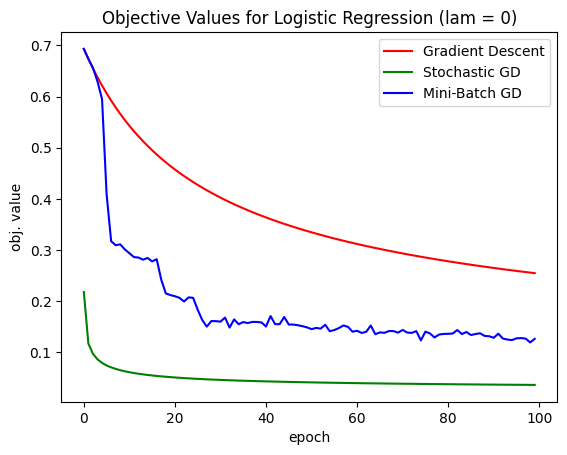

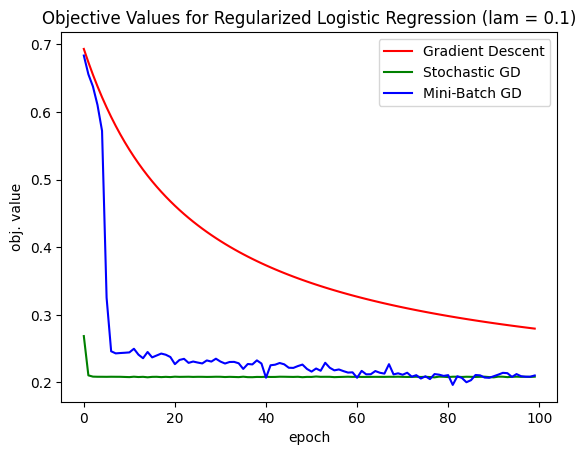

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(100), gdObjvals, label="Gradient Descent", color="red")
plt.plot(range(100), sgdObjvals, label="Stochastic GD", color="green")
plt.plot(range(100), mbgdObjvals, label="Mini-Batch GD", color="blue")
plt.legend()
plt.title("Objective Values for Logistic Regression (lam = 0)")
plt.ylabel("obj. value")
plt.xlabel("epoch")
plt.show()




plt.plot(range(100), gdObjvalsReg, label="Gradient Descent", color="red")
plt.plot(range(100), sgdObjvalsReg, label="Stochastic GD", color="green")
plt.plot(range(100), mbgdObjvalsReg, label="Mini-Batch GD", color="blue")
plt.legend()
plt.title("Objective Values for Regularized Logistic Regression (lam = 0.1)")
plt.ylabel("obj. value")
plt.xlabel("epoch")
plt.show()

# 5. Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [20]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    return numpy.sign(numpy.dot(X, w))

In [21]:
# evaluate training error of logistric regression and regularized version
gdPredict = predict(gdWeights, x_train)
gdRegPredict = predict(gdWeightsReg, x_train)
sgdPredict = predict(sgdWeights, x_train)
sgdRegPredict = predict(sgdWeightsReg, x_train)
mbgdPredict = predict(mbgdWeights, x_train)
mbgdRegPredict = predict(mbgdWeightsReg, x_train)

gdDiff = gdPredict - y_train
gdMSE = numpy.mean(gdDiff * gdDiff)
print(f"gradient descent error = \t\t{gdMSE}")

gdRegDiff = gdRegPredict - y_train
gdRegMSE = numpy.mean(gdRegDiff * gdRegDiff)
print(f"gradient descent regularized error = \t{gdRegMSE}")

sgdDiff = sgdPredict - y_train
sgdMSE = numpy.mean(sgdDiff * sgdDiff)
print(f"stochastic error = \t\t\t{sgdMSE}")

sgdRegDiff = sgdRegPredict - y_train
sgdRegMSE = numpy.mean(sgdRegDiff * sgdRegDiff)
print(f"stochastic regularized error = \t\t{sgdRegMSE}")

mbgdDiff = mbgdPredict - y_train
mbgdMSE = numpy.mean(mbgdDiff * mbgdDiff)
print(f"mini batch error = \t\t\t{mbgdMSE}")

mbgdRegDiff = mbgdRegPredict - y_train
mbgdRegMSE = numpy.mean(mbgdRegDiff * mbgdRegDiff)
print(f"mini batch regularized error = \t\t{mbgdRegMSE}")

gradient descent error = 		0.18461538461538463
gradient descent regularized error = 	0.18461538461538463
stochastic error = 			0.035164835164835165
stochastic regularized error = 		0.06153846153846154
mini batch error = 			0.1054945054945055
mini batch regularized error = 		0.0967032967032967


In [22]:
# evaluate testing error of logistric regression and regularized version
TESTgdPredict = predict(gdWeights, x_test)
TESTgdRegPredict = predict(gdWeightsReg, x_test)
TESTsgdPredict = predict(sgdWeights, x_test)
TESTsgdRegPredict = predict(sgdWeightsReg, x_test)
TESTmbgdPredict = predict(mbgdWeights, x_test)
TESTmbgdRegPredict = predict(mbgdWeightsReg, x_test)

TESTgdDiff = TESTgdPredict - y_test
TESTgdMSE = numpy.mean(TESTgdDiff * TESTgdDiff)
print(f"TEST gradient descent error = \t\t\t{TESTgdMSE}")

TESTgdRegDiff = TESTgdRegPredict - y_test
TESTgdRegMSE = numpy.mean(TESTgdRegDiff * TESTgdRegDiff)
print(f"TEST gradient descent regularized error = \t{TESTgdRegMSE}")

TESTsgdDiff = TESTsgdPredict - y_test
TESTsgdMSE = numpy.mean(TESTsgdDiff * TESTsgdDiff)
print(f"TEST stochastic = \t\t\t\t{TESTsgdMSE}")

TESTsgdRegDiff = TESTsgdRegPredict - y_test
TESTsgdRegMSE = numpy.mean(TESTsgdRegDiff * TESTsgdRegDiff)
print(f"TEST stochastic regularized error = \t\t{TESTsgdRegMSE}")

TESTmbgdDiff = TESTmbgdPredict - y_test
TESTmbgdMSE = numpy.mean(TESTmbgdDiff * TESTmbgdDiff)
print(f"TEST mini batch error = \t\t\t{TESTmbgdMSE}")

TESTmbgdRegDiff = TESTmbgdRegPredict - y_test
TESTmbgdRegMSE = numpy.mean(TESTmbgdRegDiff * TESTmbgdRegDiff)
print(f"TEST mini batch regularized error = \t\t{TESTmbgdRegMSE}")

TEST gradient descent error = 			0.14035087719298245
TEST gradient descent regularized error = 	0.14035087719298245
TEST stochastic = 				0.21052631578947367
TEST stochastic regularized error = 		0.10526315789473684
TEST mini batch error = 			0.10526315789473684
TEST mini batch regularized error = 		0.10526315789473684


# 6. Parameters tuning

### In this section, you may try different combinations of parameters (regularization value, learning rate, etc) to see their effects on the model. (Open ended question)

lam = 0 -> 0.18461538461538463
lam = 0.1 -> 0.18461538461538463
lam = 0.25 -> 0.1934065934065934
lam = 0.5 -> 0.1934065934065934


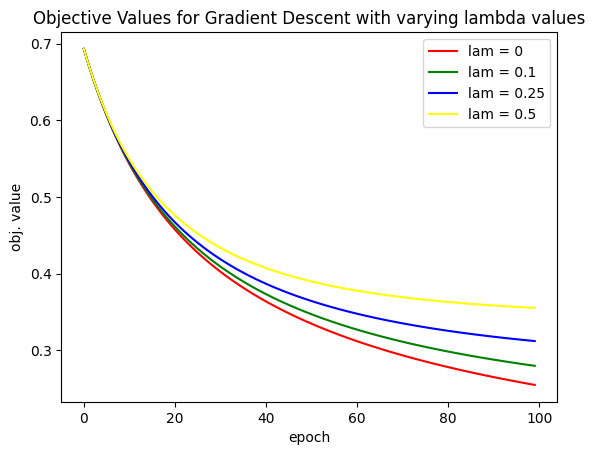

learning rate = 0.01 -> 0.18461538461538463
learning rate = 0.1 -> 0.0967032967032967
learning rate = 0.5 -> 0.07912087912087912
learning rate = 0.9 -> 0.07912087912087912


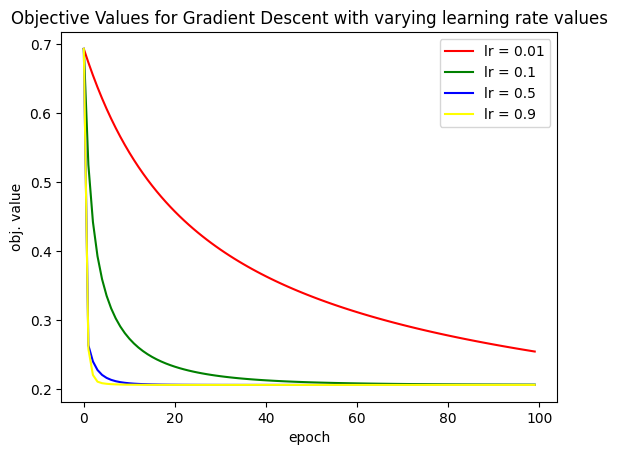

In [23]:
# params setup
largeLam = 0.25
largerLam = 0.5

largeLR = 0.1
largerLR = 0.5
largestLR = 0.9


# effects of changing lambda on MSE
print(f"lam = 0 -> {gdMSE}") # lam = 0
print(f"lam = 0.1 -> {gdRegMSE}") # lam = 0.1
init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
gdWeightsLargeLam, gdObjvalsLargeLam = gradient_descent(x_train, y_train, largeLam, 0.01, init_weight)
gdLargeLamPredict = predict(gdWeightsLargeLam, x_train)
gdLargeLamDiff = gdLargeLamPredict - y_train
gdLargeLamMSE = numpy.mean(gdLargeLamDiff * gdLargeLamDiff)
print(f"lam = {largeLam} -> {gdLargeLamMSE}")

init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
gdWeightsLargerLam, gdObjvalsLargerLam = gradient_descent(x_train, y_train, largerLam, 0.01, init_weight)
gdLargerLamPredict = predict(gdWeightsLargerLam, x_train)
gdLargerLamDiff = gdLargerLamPredict - y_train
gdLargerLamMSE = numpy.mean(gdLargerLamDiff * gdLargerLamDiff)
print(f"lam = {largerLam} -> {gdLargerLamMSE}")

plt.plot(range(100), gdObjvals, label="lam = 0", color="red")
plt.plot(range(100), gdObjvalsReg, label="lam = 0.1", color="green")
plt.plot(range(100), gdObjvalsLargeLam, label="lam = 0.25", color="blue")
plt.plot(range(100), gdObjvalsLargerLam, label="lam = 0.5", color="yellow")
plt.legend()
plt.title("Objective Values for Gradient Descent with varying lambda values")
plt.ylabel("obj. value")
plt.xlabel("epoch")
plt.show()



# effects of changing learning rate on MSE
print(f"learning rate = 0.01 -> {gdMSE}") # lr = 0.01
init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
gdWeightsLargeLR, gdObjvalsLargeLR = gradient_descent(x_train, y_train, 0.1, largeLR, init_weight)
gdLargeLRPredict = predict(gdWeightsLargeLR, x_train)
gdLargeLRDiff = gdLargeLRPredict - y_train
gdLargeLRMSE = numpy.mean(gdLargeLRDiff * gdLargeLRDiff)
print(f"learning rate = {largeLR} -> {gdLargeLRMSE}")

init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
gdWeightsLargerLR, gdObjvalsLargerLR = gradient_descent(x_train, y_train, 0.1, largerLR, init_weight)
gdLargerLRPredict = predict(gdWeightsLargerLR, x_train)
gdLargerLRDiff = gdLargerLRPredict - y_train
gdLargerLRMSE = numpy.mean(gdLargerLRDiff * gdLargerLRDiff)
print(f"learning rate = {largerLR} -> {gdLargerLRMSE}")

init_weight = numpy.array([0 for _ in range(x_train.shape[1])])
gdWeightsLargestLR, gdObjvalsLargestLR = gradient_descent(x_train, y_train, 0.1, largestLR, init_weight)
gdLargestLRPredict = predict(gdWeightsLargestLR, x_train)
gdLargestLRDiff = gdLargestLRPredict - y_train
gdLargestLRMSE = numpy.mean(gdLargestLRDiff * gdLargestLRDiff)
print(f"learning rate = {largestLR} -> {gdLargestLRMSE}")

plt.plot(range(100), gdObjvals, label="lr = 0.01", color="red")
plt.plot(range(100), gdObjvalsLargeLR, label="lr = 0.1", color="green")
plt.plot(range(100), gdObjvalsLargerLR, label="lr = 0.5", color="blue")
plt.plot(range(100), gdObjvalsLargestLR, label="lr = 0.9", color="yellow")
plt.legend()
plt.title("Objective Values for Gradient Descent with varying learning rate values")
plt.ylabel("obj. value")
plt.xlabel("epoch")
plt.show()
